In [1]:
from IPython.display import display, HTML


# Inject the CSS into the notebook
def apply_custom_styles(use_base: bool = True, custom_style: str = '') -> None:
    """Applies custom CSS styles within Jupyter notebook cell.

    Args:
        use_base (bool): Whether to use the base styles defined in the function.
                         If False, only `custom_style` will be applied. Default is True.
        custom_style (str): Additional CSS styles to apply. If `use_base` is False, this
                            will be the only style applied. If `use_base` is True, it
                            will be appended to the base styles.

    Returns:
        None
    """

    # Base CSS styles
    base_styles = '''
    <style>
    /* Font imports */
    @import url('https://fonts.googleapis.com/css2?family=Montserrat:ital,wght@0,100..900;1,100..900&family=Source+Code+Pro:ital,wght@0,200..900;1,200..900&display=swap');

    /* Variables */
    :root {
        --primary-color: #05bfa5;
        --primary-light: #FAFAFA;
        --text-color: #2c3e50;
        --code-bg: #f8f8f8;
        --code-fg: #b22222;
        --success-color: #479269;
        --warning-color: #f39c12;
        --danger-color: #e74c3c;
        --border-radius: 8px;
        --spacing-sm: 0.3em;
        --spacing-md: 1em;
        --spacing-lg: 2em;
    }

    /* Container styles */
    .h1-container, .h2-container, .h3-container {
        font-family: 'Montserrat', sans-serif;
        max-width: 95%;
        margin: var(--spacing-lg) auto;
        line-height: 1.6;
        color: var(--text-color);
    }

    /* List styles */
    .feature-list {
        background-color: var(--primary-light);
        padding: var(--spacing-sm) var(--spacing-lg);
        border-radius: var(--border-radius);
        border-left: 4px solid var(--primary-color);
        margin: var(--spacing-md) 0;
    }

    /* Code styles */
    .code-mention {
        font-family: 'Source Code Pro', monospace !important;
        background-color: var(--code-bg) !important;
        padding: 2px 5px;
        font-weight: 600 !important;
        border-radius: 4px;
        color: var(--code-fg) !important;
    }

    .code-block {
        background-color: var(--primary-light);
        border-left: 4px solid var(--primary-color);
        padding: var(--spacing-md);
        margin: var(--spacing-md) 0;
        border-radius: var(--border-radius);
        padding: var(--spacing-lg);
        max-width: 90%;
    }

    /* Information blocks */
    .note-block, .notice-block {
        padding: var(--spacing-md);
        border-radius: var(--border-radius);
        margin: var(--spacing-md) 0;
    }

    .note-block {
        background-color: var(--primary-light);
        border-left: 4px solid var(--success-color);
    }

    .notice-block {
        background-color: var(--primary-light);
        border-left: 4px solid var(--warning-color);
    }

    .note-title {
        margin-top: 0;
        color: var(--success-color);
        font-weight: 600;
    }

    .feature-list:hover {
        background-color: #f0f0f0;
    }
    .code-block:hover {
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    }

    /* Utility styles */
    .code-comment {
        color: #607d8b;
        font-style: italic;
    }

    .highlight {
        background-color: #fff176;
        padding: 2px 5px;
        border-radius: 3px;
    }
    </style>
    '''

    # Remove <style> tags if present
    if custom_style.startswith('<style>'):
        custom_style = custom_style.replace('<style>', '').replace('</style>', '')

    # Combine base styles with custom styles if requested
    final_styles = base_styles if use_base else ''
    final_styles += f"<style>{custom_style}</style>" if custom_style else ''

    # Inject the CSS into the notebook
    display(HTML(final_styles))

apply_custom_styles()

<div class="h1-container">

# 🚀 Quick Start

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

<div class="feature-list">

- <span style="color: teal; font-weight: bold;">🧠 Answer common questions w/ a basic chatbot [THIS NOTEBOOK]</span>
- 🔍 Answer common questions by searching the web
- 💾 Maintain conversation state across calls
- 🔄 Route complex queries to a human for review
- ⚙️ Use custom state to control its behavior
- 🌳 Rewind and explore alternative conversation paths

</div>

<br>

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

</div>

<div class="h2-container">

## 🎯 Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have built a rudimentary chatbot.

Start by creating a <span class="code-mention">StateGraph</span>. 

A <span class="code-mention">StateGraph</span> object defines the structure of our chatbot as a "state machine". We'll add <span class="code-mention">nodes</span> to represent the LLM and functions our chatbot can call and <span class="code-mention">edges</span> to specify how the bot should transition between these functions.

</div>

In [2]:
# Standard library imports
import os
import sys
import json
import time
import random
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display

# Third-party imports
from dotenv import load_dotenv, find_dotenv
from colorama import Back, Fore, Style, init
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langchain_openai import ChatOpenAI


def get_color(color: str | None = None, is_background: bool = False) -> str:
    """Fetches the foreground or background color from colorama dynamically based on the color name.

    Args:
        color (str | None): 
            The name of the color. 
            Options are: 
                - "red", "green", "yellow", "blue", "magenta", "cyan", "white".
        is_background (bool): 
            If True, fetches the background color (from `Back`). 
            If False, fetches the foreground color (from `Fore`).

    Returns:
        str: The ANSI escape sequence for the requested color.

    Raises:
        ValueError: If an invalid color name is provided.
    """
    if not color:
        return ""
    
    # Select the colorama module (Fore for foreground, Back for background)
    colorama_module = Back if is_background else Fore
    color_attr = color.upper()  # Convert color name to uppercase to match colorama attributes
    
    try:
        # Dynamically retrieve the color attribute from Fore or Back
        return getattr(colorama_module, color_attr)
    except AttributeError:
        raise ValueError(f"Invalid color '{color}'. Valid options are: red, green, yellow, blue, magenta, cyan, white.")

def cprint(
    text: str, 
    fg_color: str | None = None, 
    bg_color: str | None = None,
    bold: bool = False,
    dim: bool = False,
    underline: bool = False, 
    prefix_text: str = "",
    bold_prefix: bool = False,
    dim_prefix: bool = False,
    underline_prefix: bool = False, 
    return_formatted_text: bool = False
) -> str | None:
    """Formats and prints text with specified foreground and background colors, weight, and additional styling.

    Args:
        text (str): 
            The main text to be formatted.
        fg_color (str, optional): 
            The name of the Foreground color. 
            Options are: 
                - "red", "green", "yellow", "blue", "magenta", "cyan", "white".
        bg_color (str, optional): 
            The name of the Background color. Same options as FG.
        bold (bool): 
            If True, makes the main text bold.
        dim (bool): 
            If True, dims the main text.
        underline (bool): 
            If True, underlines the main text.
        prefix_text (str): 
            Optional prefix text to be formatted and displayed before the main text.
        bold_prefix (bool): 
            If True, makes the prefix text bold.
        dim_prefix (bool): 
            If True, dims the prefix text.
        underline_prefix (bool): 
            If True, underlines the prefix text.
        return_formatted_text (bool): 
            If True, returns the formatted text as a string instead of printing it.

    Returns:
        str | None: Formatted text string if `return_formatted_text` is True, otherwise None.

    Raises:
        ValueError: If an invalid foreground or background color is provided.
    """
    
    # Helper function to build formatted text based on parameters
    def format_text(text: str, fg_color: str | None, bg_color: str | None, bold: bool, dim: bool, underline: bool) -> str:
        """Helper function to format text using Colorama styling."""
        formatted = ""
        if fg_color:
            formatted += get_color(fg_color)
        if bg_color:
            formatted += get_color(bg_color, is_background=True)
        if bold:
            formatted += Style.BRIGHT
        elif dim:
            formatted += Style.DIM
        if underline:
            formatted += "\033[4m"  # ANSI code for underline
        return formatted + text + Style.RESET_ALL

    # Format the prefix text with default main text styling, modified by any prefix-specific flags
    formatted_prefix = ""
    if prefix_text:
        # Apply the same fg_color and bg_color as the main text, and apply bold, dim, underline only if specified for the prefix
        formatted_prefix = format_text(
            prefix_text,
            fg_color=fg_color,
            bg_color=bg_color,
            bold=bold_prefix if bold_prefix else bold,
            dim=dim_prefix if dim_prefix else dim,
            underline=underline_prefix if underline_prefix else underline
        )

    # Format the main text with specified styling
    formatted_text = format_text(
        text,
        fg_color=fg_color,
        bg_color=bg_color,
        bold=bold,
        dim=dim,
        underline=underline
    )

    # Combine prefix and main text
    final_output = formatted_prefix + formatted_text

    # Return or print the final output based on `return_formatted_text`
    if return_formatted_text:
        return final_output
    print(final_output)


def setup_environment(verbose=True):
    """Set up the environment variables and initialize core components.
    
    Returns:
        bool: True if environment variables were loaded successfully
    """
    if load_dotenv(find_dotenv()):
        cprint("\n✅ Environment Variables Loaded Successfully\n", fg_color="green", bold=True)
    else:
        cprint("\n❌ Environment Variables Failed to Load\n", fg_color="red", bold=True)
    


class State(TypedDict):
    """Defines the state schema for the chatbot graph.
    
    Attributes:
        messages (Annotated[list, add_messages]): List of conversation messages.
            Uses add_messages reducer to append rather than overwrite messages.
    """
    messages: Annotated[list, add_messages]
    

def initialize_graph():
    """Initialize the StateGraph with the defined State schema.
    
    Returns:
        StateGraph: Configured graph builder instance
    """
    return StateGraph(State)


def chatbot(state: State) -> dict:
    """Process the current state and generate a response using the language model.
    
    Args:
        state (State): Current state containing conversation messages
        
    Returns:
        dict: Updated state with new message appended
    """
    return {"messages": [llm.invoke(state["messages"])]}


# Initialize environment
ENV_LOADED = setup_environment()


✅ Environment Variables Loaded Successfully



In [3]:
# Initialize the graph builder
graph_builder = initialize_graph()

# Initialize the language model
llm = ChatOpenAI(model="gpt-4o")

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

print(graph_builder)
display(graph_builder.__dict__)

{'nodes': {'chatbot': StateNodeSpec(runnable=chatbot(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.State'>, retry_policy=None)},
 'edges': set(),
 'branches': defaultdict(dict, {}),
 'support_multiple_edges': False,
 'compiled': False,
 'schemas': {__main__.State: {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x10432f100>}},
 'channels': {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x10432f100>},
 'managed': {},
 'schema': __main__.State,
 'input': __main__.State,
 'output': __main__.State,
 'config_schema': None,
 'waiting_edges': set()}

<div class="note-block">
    <h4 class="note-title">Understanding the Graph Structure</h4>
    <p>
        Our graph now understands two key concepts:
    </p>
    <ol>
        <li>Each <code class="code-mention">node</code> we define will:
            <ul>
                <li>Receive the current <code class="code-mention">State</code> as input</li>
                <li>Return a value that updates that state</li>
            </ul>
        </li>
        <li>The <code class="code-mention">messages</code> will be <span class="highlight"><b>appended</b></span> to the current list, rather than directly overwritten. This behavior is defined through the <code class="code-mention">add_messages</code> function in the <code class="code-mention">Annotated</code> syntax.</li>
    </ol>
</div>

<div class="notice-block">
    <h4 style="margin-top: 0; color: #ff5722;">Important Implementation Detail</h4>
    <p>
        Notice how the <code class="code-mention">chatbot</code> node function...
        <ol>
            <li>Takes the current <code class="code-mention">State</code> as input</li>
            <li>Returns a dictionary containing an updated <code class="code-mention">messages</code> list under the key "messages"</li>
        </ol>
        <b>This is the fundamental pattern for all LangGraph node functions.</b> The <code class="code-mention">add_messages</code> function in our <code class="code-mention">State</code> will append the LLM's response messages to the existing message history.
    </p>
</div>


<div class="h3-container">

### 🪧 Graph Navigation: Entry and Exit Points

Next, we need to add an <b>entry</b> and <b>exit</b> point. 
- The <code class="code-mention">START</code> node tells our graph where to **"start your work here"** each time we run it.
- The <code class="code-mention">END</code> node instructs our graph that **"any time this node is run, you can exit."**

</div>

In [4]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

print(graph_builder)
display(graph_builder.__dict__)

{'nodes': {'chatbot': StateNodeSpec(runnable=chatbot(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.State'>, retry_policy=None)},
 'edges': {('__start__', 'chatbot'), ('chatbot', '__end__')},
 'branches': defaultdict(dict, {}),
 'support_multiple_edges': False,
 'compiled': False,
 'schemas': {__main__.State: {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x10432f100>}},
 'channels': {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x10432f100>},
 'managed': {},
 'schema': __main__.State,
 'input': __main__.State,
 'output': __main__.State,
 'config_schema': None,
 'waiting_edges': set()}

<div class="h3-container">

### 🔄 Compiling and Visualizing the Graph

Now that we've defined our graph structure, we need to make it executable and inspect it.
- The <code class="code-mention">compile()</code> method creates a **"CompiledGraph"** that we can invoke with our state
- The <code class="code-mention">get_graph()</code> method allows us to **visualize** our graph structure using various rendering options

You can visualize the graph using the <code class="code-mention">get_graph</code> method and one of the "draw" methods, like <code class="code-mention">draw_ascii</code> or <code class="code-mention">draw_png</code>. 

**NOTE:** The <code class="code-mention">draw</code> methods each require additional dependencies.

</div>


🧜‍♀️ Mermaid Chart for Our Graph



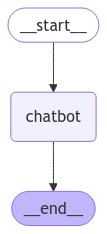

In [5]:
graph = graph_builder.compile()

cprint("\n🧜‍♀️ Mermaid Chart for Our Graph\n", fg_color="blue", bold=True)
display(Image(graph.get_graph().draw_mermaid_png()))

<div class="h3-container">

### 🤖 Running Your Chatbot

Let's run the bot! We've added some prettified features to make things look a bit better...

<div class="feature-list">

- 🎯 Interactive chat interface with colorized output
- 🚪 Multiple exit commands supported
- 🛡️ Error handling and graceful fallbacks
- 🔄 Stream-based response processing
- 💬 Message history tracking

</div>

</div>

In [7]:
def run_interactive_chat(graph: CompiledStateGraph) -> None:
    """Run the interactive chat interface with enhanced printing capabilities.

    Args:
        graph (CompiledStateGraph): The compiled LangGraph instance
    """
    EXIT_COMMANDS = {"quit", "exit", "q", "bye", "goodbye"}
    message_history = []
    
    # Display welcome banner
    cprint("\n"+"="*50, fg_color="blue", bold=True)
    cprint("🦜 Welcome to LangGraph Chat!", fg_color="yellow", bold=True)
    cprint("Type 'quit', 'exit', 'bye', 'goodbye', or 'q' to end the conversation", fg_color="white", bold=True)
    cprint("="*50+"\n", fg_color="blue", bold=True)

    # Start interaction loop
    while True:
        try:
            # Get user input with styled prompt
            user_input = input("User Input: ")
            
            # Check for exit command
            if user_input.lower() in EXIT_COMMANDS:
                cprint("\n👋 Goodbye! Thanks for chatting!\n", fg_color="yellow", bold=True)
                break
            
            # Process user message through graph
            message_history.append(("user", user_input))
            
            try:
                for event in graph.stream({"messages": message_history}):
                    for value in event.values():
                        response = value["messages"][-1].content
                        message_history.append(("assistant", response))
                        cprint(text=response, prefix_text="Assistant: ", fg_color="green", bold_prefix=True)
            except Exception as e:
                cprint(f"Error processing message: {str(e)}", bg_color="red", bold=True)
                
        except KeyboardInterrupt:
            cprint("\nChat session interrupted. 👋 Goodbye!", fg_color="yellow", bold=True)
            break
            
        except Exception as e:
            enhanced_cprint(f"An error occurred: {str(e)}", color="red")
            enhanced_cprint("Falling back to demo mode...", color="yellow")
            
            # Fallback demo mode
            demo_input = "What do you know about LangGraph?"
            cprint(demo_input, fg_color="teal", prefix_text="User: ", bold_prefix=True)
            message_history.append(("user", demo_input))
            for event in graph.stream({"messages": message_history}):
                for value in event.values():
                    response = value["messages"][-1].content
                    cprint(text=response, prefix_text="Assistant", fg_color="green", bold_prefix=True)
            break


run_interactive_chat(graph)


🦜 Welcome to LangGraph Chat!
Type 'quit', 'exit', 'bye', 'goodbye', or 'q' to end the conversation



User Input:  What is VMware


Assistant: VMware is a prominent software company that specializes in cloud computing and virtualization technology. Founded in 1998, VMware is known for its pioneering work in virtualization, which involves creating a virtual version of a physical device or resource, such as a server, storage device, or network. This technology allows multiple virtual machines (VMs) to run on a single physical machine, enabling more efficient use of resources and flexibility in managing IT infrastructure.

Key products and technologies offered by VMware include:

1. **VMware vSphere**: This is VMware's flagship product, a virtualization platform for managing virtualized data centers. It includes the ESXi hypervisor, which is responsible for running virtual machines on physical servers.

2. **VMware NSX**: A network virtualization and security platform that enables the creation and management of virtual networks.

3. **VMware vSAN**: A software-defined storage solution that enables the pooling of stora

<div class="h3-container">

### 🎉 Congratulations!

You've successfully built your first LangGraph chatbot! This implementation includes:

1. **Enhanced User Experience**
   - Colorized output for better readability
   - Typing effect for more natural interaction
   - Comprehensive error handling
   - Message history tracking
2. **Professional Features**
   - Structured message formatting
   - Clean exit handling
   - Graceful error recovery
   - Demo mode fallback
3. **Code Quality**
   - Type hints for better maintainability
   - Comprehensive docstrings
   - Modular function design
   - Constants for configuration

<div class="notice-block">
<h4 style="margin-top: 0; color: var(--warning-color);">🔍 Next Steps</h4>

You may have noticed that the bot's knowledge is limited to its training data. In the next section, we'll explore how to:
- Add web search capabilities
- Implement memory management
- Handle complex query routing
- Add custom state controls

Check out a [**LangSmith Trace**](https://smith.langchain.com/public/7527e308-9502-4894-b347-f34385740d5a/r) of the bot in action!
</div>

Finally, if you would like to see the end-to-end original implementation for reference... check it out below (this is directly from <a href="https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot"><b>here</b></a>).

<div class="code-block">
<details>
<summary style="cursor: pointer; color: var(--primary-color); font-weight: bold;">📚 Complete Reference Implementation</summary>

<br>

```python
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Define the state schema
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize core components
graph_builder = StateGraph(State)
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

def chatbot(state: State) -> dict:
    """Process chat state and generate response."""
    return {"messages": [llm.invoke(state["messages"])]}

# Configure graph structure
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

# Compile for execution
graph = graph_builder.compile()
```

</details>
</div>
</div>